In [12]:
import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

from __future__ import unicode_literals

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer, UniformChargeSlicer
from PyHEADTAIL_feedback.feedback import IdealBunchFeedback,IdealSliceFeedback,OneboxFeedback
from PyHEADTAIL_feedback.signal_processors import PhaseLinearizedLowpass, IdealSlice, IdealBunch, ChargeWeighting
from PyHEADTAIL_feedback.signal_processors import Register
from PyHEADTAIL_feedback.feedback import PickUp, Kicker
from PyHEADTAIL_feedback.signal_mixers import Averager
np.random.seed(0)

In [13]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

In [14]:
def track(n_turns, bunch, total_map, bunch_dump):
    
    for i in xrange(n_turns):
        bunch_dump.dump()
        
        for m_ in total_map:
            m_.track(bunch)

In [15]:
class BunchDump(object):
    def __init__(self,bunch):
        self.counter = 0

        self.bunch = bunch
        self.turn = np.array([])

        self.mean_x = np.array([])
        self.mean_y = np.array([])
        self.mean_z = np.array([])

        self.mean_xp = np.array([])
        self.mean_yp = np.array([])
        self.mean_dp = np.array([])

        self.sigma_x = np.array([])
        self.sigma_y = np.array([])
        self.sigma_z = np.array([])

        self.sigma_xp = np.array([])
        self.sigma_yp = np.array([])
        self.sigma_dp = np.array([])

        self.epsn_x = np.array([])
        self.epsn_y = np.array([])
        self.epsn_z = np.array([])

    def dump(self):
        self.turn=np.append(self.turn,[self.counter])
        self.counter += 1

        self.mean_x=np.append(self.mean_x,[self.bunch.mean_x()])
        self.mean_y=np.append(self.mean_y,[self.bunch.mean_y()])
        self.mean_z=np.append(self.mean_z,[self.bunch.mean_z()])

        self.mean_xp=np.append(self.mean_xp,[self.bunch.mean_xp()])
        self.mean_yp=np.append(self.mean_yp,[self.bunch.mean_yp()])
        self.mean_dp=np.append(self.mean_dp,[self.bunch.mean_dp()])

        self.sigma_x=np.append(self.sigma_x,[self.bunch.sigma_x()])
        self.sigma_y=np.append(self.sigma_y,[self.bunch.sigma_y()])
        self.sigma_z=np.append(self.sigma_z,[self.bunch.sigma_z()])

        self.sigma_xp=np.append(self.sigma_xp,[self.bunch.sigma_xp()])
        self.sigma_yp=np.append(self.sigma_yp,[self.bunch.sigma_yp()])
        self.sigma_dp=np.append(self.sigma_dp,[self.bunch.sigma_dp()])

        self.epsn_x = np.append(self.epsn_x,[self.bunch.epsn_x()])
        self.epsn_y = np.append(self.epsn_y,[self.bunch.epsn_y()])
        self.epsn_z = np.append(self.epsn_z,[self.bunch.epsn_z()])

In [16]:
def compare_bunch_dumps(dump_0,dump_1):
    fig = plt.figure(figsize=(16, 8))
    ax_x_mean = fig.add_subplot(231)
    ax_x_sigma = fig.add_subplot(232)
    ax_x_epsn = fig.add_subplot(233)
    
    ax_x_mean.plot(dump_0.turn, dump_0.mean_x*1000,'k-',dump_1.turn, dump_1.mean_x*1000,'b-')
    ax_x_mean.set_ylabel('<x> [mm]')
    ax_x_mean.ticklabel_format(useOffset=False)
    
    ax_x_sigma.plot(dump_0.turn, dump_0.sigma_x*1000,'k-',dump_1.turn, dump_1.sigma_x*1000,'b-')
    ax_x_sigma.set_ylabel('sigma_x [mm]')
    ax_x_sigma.ticklabel_format(useOffset=False)
    
    ax_x_epsn.plot(dump_0.turn, dump_0.epsn_x*1e6,'k-',dump_1.turn, dump_1.epsn_x*1e6,'b-')
    ax_x_epsn.set_ylabel('epsn_x [mm mrad]')
    ax_x_epsn.set_xlabel('Turn')
    ax_x_epsn.ticklabel_format(useOffset=False)
    
    ax_y_mean = fig.add_subplot(234)
    ax_y_sigma = fig.add_subplot(235)
    ax_y_epsn = fig.add_subplot(236)
    
    
    ax_y_mean.plot(dump_0.turn, dump_0.mean_y*1000,'k-',dump_1.turn, dump_1.mean_y*1000,'r-')
    ax_y_mean.set_ylabel('<y> [mm]')
    ax_y_mean.ticklabel_format(useOffset=False)
    
    ax_y_sigma.plot(dump_0.turn, dump_0.sigma_y*1000,'k-',dump_1.turn, dump_1.sigma_y*1000,'r-')
    ax_y_sigma.set_ylabel('sigma_y [mm]')
    ax_y_sigma.ticklabel_format(useOffset=False)
    
    ax_y_epsn.plot(dump_0.turn, dump_0.epsn_y*1e6,'k-',dump_1.turn, dump_1.epsn_y*1e6,'r-')
    ax_y_epsn.set_ylabel('epsn_y  [mm mrad]')
    ax_y_epsn.set_xlabel('Turn')
    ax_y_epsn.ticklabel_format(useOffset=False)

    plt.show()

In [17]:
def plot_projections( bunch_ref, bunch_feedback):
    fig = plt.figure(figsize=(16, 5))
    ax_z_x = fig.add_subplot(121)
    ax_z_y = fig.add_subplot(122)
    
    ax_z_x.plot(bunch_ref.z,bunch_ref.x*1000,'k.',bunch_feedback.z,bunch_feedback.x*1000,'b.')
    ax_z_x.set_xlabel('z [m]')
    ax_z_x.set_ylabel('x [mm]')
    ax_z_y.plot(bunch_ref.z,bunch_ref.y*1000,'k.',bunch_feedback.z,bunch_feedback.y*1000,'r.')
    ax_z_y.set_xlabel('z [m]')
    ax_z_y.set_ylabel('y [mm]')

### Basic parameters

In [18]:
n_turns = 200
n_segments = 4
n_macroparticles = 1000

feedback_gain = 0.1

#Q_x = 64.28
#Q_y = 59.31
Q_x = 59.31
Q_y = 64.28
Q_s = 0.000000000001
#Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_0 = [0.0003225]

### Transverse and longitunal maps

In [19]:
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
    
alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)
        
trans_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)
print 's includes ' + str(len(s)) + ' elements and trans_map ' + str(len(trans_map)) + ' elements'
long_map = LinearMap(alpha_0, C, Q_s)

s includes 5 elements and trans_map 4 elements


### Kicked bunch

In [20]:
bunch_ref = generate_bunch(n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,long_map)

n_sigma_z = 3
n_slices = 15
slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

#initial kick
slice_set = bunch_ref.get_slices(slicer, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

#random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_0 = copy.deepcopy(bunch_ref)
dump_ref = BunchDump(bunch_0)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_0,maps_ref,dump_ref)

## Reference data from ideal feedbacks

In [21]:
bunch_ideal_bunch_FB = copy.deepcopy(bunch_ref)
dump_ideal_bunch_FB = BunchDump(bunch_ideal_bunch_FB)
feedback_map = IdealBunchFeedback(feedback_gain)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]
track(n_turns, bunch_ideal_bunch_FB,total_map_FB,dump_ideal_bunch_FB)

bunch_ideal_slice_FB = copy.deepcopy(bunch_ref)
dump_ideal_slice_FB = BunchDump(bunch_ideal_slice_FB)
feedback_map = IdealSliceFeedback(feedback_gain,slicer)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]
track(n_turns, bunch_ideal_slice_FB,total_map_FB,dump_ideal_slice_FB)

## Phase linearized feedback with ideal pickup

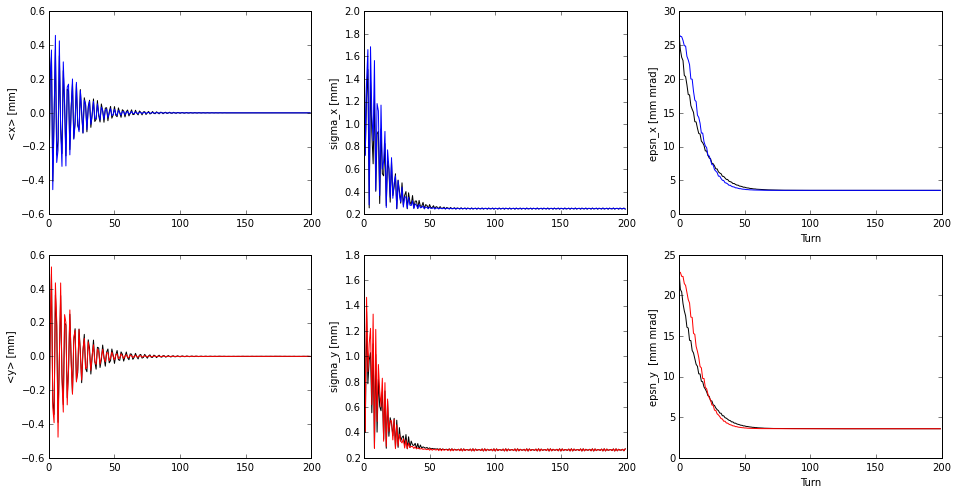

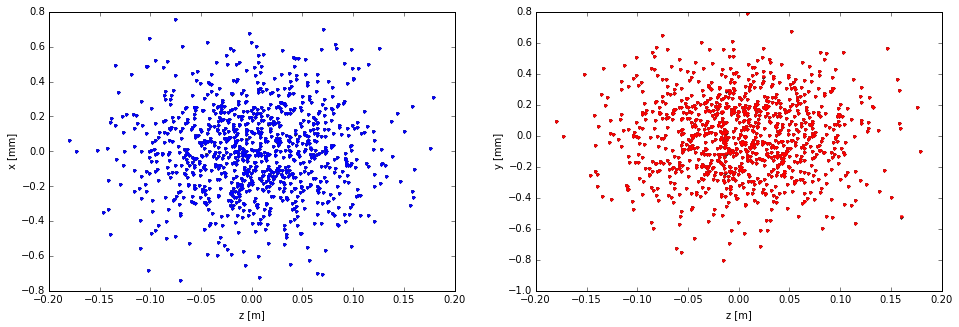

In [22]:
bunch_slow_FB = copy.deepcopy(bunch_ref)
dump_slow_FB = BunchDump(bunch_slow_FB)
f_cutoff = 1e10

#Phase angles
p1_x = 0.
p1_y = 0.
p2_x = (1./4.)*Q_x*2.*pi
p2_y = (1./4.)*Q_y*2.*pi
p3_x = (2./4.)*Q_x*2.*pi
p3_y = (2./4.)*Q_y*2.*pi
p4_x = (3./4.)*Q_x*2.*pi
p4_y = (3./4.)*Q_y*2.*pi

#Phase shift per turn
delta_Phi_x = Q_x*2.*pi
delta_Phi_y = Q_y*2.*pi

#Register settings
register_length = 10
register_avg = 10

#processors_p1_x = [PhaseLinearizedLowpass(f_cutoff),Register(register_length,delta_Phi_x, register_avg,p1_x)]
#processors_p1_y = [PhaseLinearizedLowpass(f_cutoff),Register(register_length,delta_Phi_y, register_avg,p1_y)]
#processors_p2_x = [PhaseLinearizedLowpass(f_cutoff),Register(register_length,delta_Phi_x, register_avg,p2_x)]
#processors_p2_y = [PhaseLinearizedLowpass(f_cutoff),Register(register_length,delta_Phi_y, register_avg,p2_y)]
#processors_p3_x = [PhaseLinearizedLowpass(f_cutoff),Register(register_length,delta_Phi_x, register_avg,p3_x)]
#processors_p3_y = [PhaseLinearizedLowpass(f_cutoff),Register(register_length,delta_Phi_y, register_avg,p3_y)]
#processors_p4_x = [PhaseLinearizedLowpass(f_cutoff),Register(register_length,delta_Phi_x, register_avg,p4_x)]
#processors_p4_y = [PhaseLinearizedLowpass(f_cutoff),Register(register_length,delta_Phi_y, register_avg,p4_y)]

processors_p1_x = [Register(register_length,delta_Phi_x, register_avg,p1_x)]
processors_p1_y = [Register(register_length,delta_Phi_y, register_avg,p1_y)]
processors_p2_x = [Register(register_length,delta_Phi_x, register_avg,p2_x)]
processors_p2_y = [Register(register_length,delta_Phi_y, register_avg,p2_y)]
processors_p3_x = [Register(register_length,delta_Phi_x, register_avg,p3_x)]
processors_p3_y = [Register(register_length,delta_Phi_y, register_avg,p3_y)]
processors_p4_x = [Register(register_length,delta_Phi_x, register_avg,p4_x)]
processors_p4_y = [Register(register_length,delta_Phi_y, register_avg,p4_y)]

pickup_1 = PickUp(slicer,processors_p1_x,processors_p1_y)
pickup_2 = PickUp(slicer,processors_p2_x,processors_p2_y)
pickup_3 = PickUp(slicer,processors_p3_x,processors_p3_y)
pickup_4 = PickUp(slicer,processors_p4_x,processors_p4_y)

processors_k1_x = [IdealSlice()]
processors_k1_y = [IdealSlice()]
processors_k2_x = [IdealSlice()]
processors_k2_y = [IdealSlice()]

mixer_k1_x = Averager('x',p2_x)
mixer_k1_y = Averager('y',p2_y)
mixer_k2_x = Averager('x',p4_x)
mixer_k2_y = Averager('y',p4_y)

pickup_list = [pickup_1,pickup_2,pickup_3,pickup_4]

kicker_1 = Kicker(feedback_gain,slicer,pickup_list,processors_k1_x,processors_k1_y,mixer_k1_x,mixer_k1_y)
kicker_2 = Kicker(feedback_gain,slicer,pickup_list,processors_k2_x,processors_k2_y,mixer_k2_x,mixer_k2_y)

#total_map_FB = [pickup_1] + [trans_map[0]] + [pickup_2] + [kicker_1] + [trans_map[1]] + \
#               [pickup_3] + [trans_map[2]] + [pickup_4] + [kicker_2] + [trans_map[3]] + [long_map] 
    
total_map_FB = [pickup_1] + [trans_map[0]] + [pickup_2] + [trans_map[1]] + \
               [pickup_3] + [trans_map[2]] + [pickup_4] + [kicker_2] + [trans_map[3]] + [long_map] 

track(n_turns, bunch_slow_FB,total_map_FB,dump_slow_FB)

compare_bunch_dumps(dump_ideal_slice_FB,dump_slow_FB)
plot_projections(bunch_ideal_slice_FB,bunch_slow_FB)